# Name Entity Recognition using BiLstm 

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ner_datasetreference.csv to ner_datasetreference.csv


In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('ner_datasetreference.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [5]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,25314,16
1,NaN,of,IN,O,21115,16
2,NaN,demonstrators,NNS,O,30777,16
3,NaN,have,VBP,O,20896,16
4,NaN,marched,VBN,O,23024,16
...,...,...,...,...,...,...
1048570,NaN,they,PRP,O,3274,16
1048571,NaN,responded,VBD,O,4186,16
1048572,NaN,to,TO,O,4158,16
1048573,NaN,the,DT,O,3568,16


In [6]:
data_fillna = data.fillna(method='ffill', axis=0)

In [7]:
data_group=data_fillna.groupby(['Sentence #'],as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

In [8]:
data_group.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[25314, 21115, 30777, 20896, 23024, 26050, 139...","[16, 16, 16, 16, 16, 16, 1, 16, 16, 16, 16, 16..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[16559, 9333, 13572, 3274, 21509, 4158, 32303,...","[11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[25034, 11753, 157, 25161, 378, 16277, 27267, ...","[16, 16, 9, 16, 16, 16, 16, 16, 1, 16, 16, 16,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[11458, 24866, 23355, 23473, 22120, 7248, 1713...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[18908, 1480, 21928, 11505, 13197, 18191, 2108...","[1, 16, 16, 4, 12, 16, 9, 16, 1, 16, 11, 16, 1..."


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [10]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    print(pad_tokens[:10])
    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    print(pad_tags[:10])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)


[[25314 21115 30777 ... 35177 35177 35177]
 [16559  9333 13572 ... 35177 35177 35177]
 [25034 11753   157 ... 35177 35177 35177]
 ...
 [26595 23895 27403 ... 35177 35177 35177]
 [ 4456  3218 27055 ... 35177 35177 35177]
 [27639 10475 27098 ... 35177 35177 35177]]
[[16 16 16 ... 16 16 16]
 [11 16 16 ... 16 16 16]
 [16 16  9 ... 16 16 16]
 ...
 [16 16 16 ... 16 16 16]
 [16 16 16 ... 16 16 16]
 [11 16 16 ... 16 16 16]]
train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [11]:
len(train_tokens[0])

104

In [12]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model


In [13]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [14]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])

In [15]:
input_dim

35179

In [16]:
n_tags = len(tag2idx)

In [17]:
output_dim=64
input_dim=35179
input_length=104
n_tags=17

In [18]:
print(n_tags)

17


In [19]:
def get_billstm_model():
  model=Sequential()
  model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length))
  #add bidirectional Lstm
  model.add(Bidirectional(LSTM(units=output_dim,return_sequences=True,dropout=.2,recurrent_dropout=.5)))
  # add Lstm
  
  model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
  #add time distributed layer
  model.add(TimeDistributed(Dense(n_tags, activation="relu")))

  adam = tensorflow.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [20]:
def train_model(X, y, model):
    loss = list()
    for i in range(10):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           2251456   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 128)         66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 104, 64)           49408     
                                                                 
 time_distributed (TimeDistr  (None, 104, 17)          1105      
 ibuted)                                                         
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


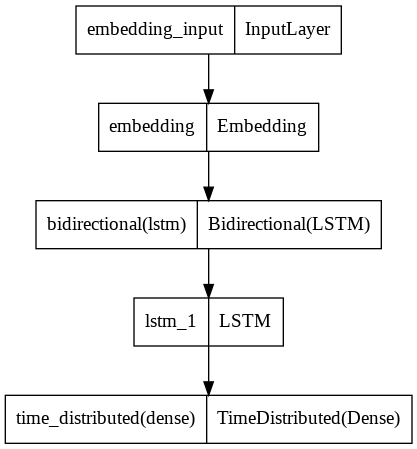

In [21]:
results = pd.DataFrame()
model_bilstm_lstm = get_billstm_model()
plot_model(model_bilstm_lstm)

In [22]:
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

26/26 [==============================] - 33s 1s/step - loss: 0.1873 - accuracy: 0.9678 - val_loss: 0.1832 - val_accuracy: 0.9682


In [24]:
import matplotlib.pyplot as plt

In [30]:
data=results.values

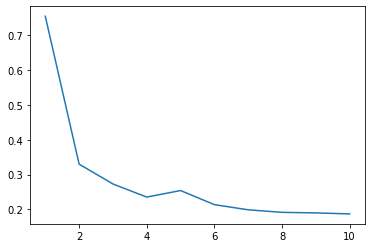

In [32]:
plt.plot([1,2,3,4,5,6,7,8,9,10],data)